# Exercise sheet 5 with the files bitcoin.csv and dictionary.csv. Load the data set into your console.

# Task 1
In Moodle you will find the file bitcoin.csv, containing Reddit comments of the bitcoin- Subreddit from 2022. Read the file into your console.

From this data set, we only need the columns “created”, determining the date at which the post was created, “title” containing the title of the post and ”selftext” containing additional text from the post, if any. For our analysis, we want to analyze “title” and “selftext” as one combined entitiy for each text. So for each post, join the two respective strings if there is a selftext.

We will now perform a simple sentiment analysis and compare the resulting time series with the actual Bitcoin price, which you can find in bitcoin prices.csv.

In [2]:
import pandas as pd
import numpy as np
import re
from datetime import datetime

In [3]:
import pandas as pd

# Load your CSV file
bitcoin_df = pd.read_csv('/Users/oayanwale/Downloads/NLP_Exercise_23/bitcoin.csv')
prices_df = pd.read_csv('/Users/oayanwale/Downloads/NLP_Exercise_23/bitcoin_prices.csv')
dictionary_df =  pd.read_csv('/Users/oayanwale/Downloads/NLP_Exercise_23/dictionary.csv')


# bitcoin_df.head()
prices_df.head()
#dictionary_df.head()

,timestamp,difference
0,2022-01-01,-842.52
1,2022-01-02,1490.70
2,2022-01-03,-495.08
3,2022-01-04,-734.92
4,2022-01-05,-610.64


In [4]:
# Select relevant columns
bitcoin_df = bitcoin_df[["created", "title", "selftext"]]

# Combine title and selftext into one text column
bitcoin_df["text"] = bitcoin_df["title"] + " " + bitcoin_df["selftext"].fillna("")

# Convert created column to datetime
bitcoin_df["created"] = pd.to_datetime(bitcoin_df["created"], unit='s')
bitcoin_df["date"] = bitcoin_df["created"].dt.date

# Task 2
# Apply preprocessing to the given texts. Keep in mind, that we intend to use sentiment dictionar- ies to analyze the text later. 
# How does this knowledge change your approach to preprocessing?


In [5]:
# Task 2: Preprocessing Function
def preprocess_text(text):
    if isinstance(text, str):  # Check if text is a string
        text = text.lower()  # Convert to lowercase
        text = re.sub(r"[^\w\s']", '', text)  # Remove special characters but keep words and apostrophes
        return text.strip()  # Remove leading/trailing spaces
    return ""  # Return empty string for NaN or non-string values

bitcoin_df["processed_text"] = bitcoin_df["text"].apply(preprocess_text)

Considerations for Preprocessing:

Lowercasing ✅ (Already done)
Necessary to ensure case-insensitive matching with the dictionary.

Removing Non-Alphabetical Characters ⚠️
While removing numbers and special characters makes sense, we need to be careful with things like hyphens (e.g., "well-being") or contractions (e.g., "don't").
Instead of removing everything, we should selectively handle punctuation.

✔ Stripped unnecessary spaces.

Stopword Removal ❌ (Avoid it!)
Normally, stopwords like “the” or “is” are removed in text analysis, but for sentiment analysis, they may affect meaning (e.g., "not good" should not become just "good").
We should retain negations like "not" or "never" because they influence sentiment.

Lemmatization/Stemming ❌ (Avoid it!)
Sentiment dictionaries often contain words in their base form, but stemming (e.g., "running" → "run") or lemmatization could lead to mismatches if our dictionary doesn’t have the stemmed word.

It's safer to keep words as they are unless we check our dictionary’s format.

# Task 3
# In dictionary.csv you will find a sentiment dictionary. “Positive words” will have positive values while “Negative words” will have negative values.

# Use this dictionary to calculate the sentiment score of each text, that is sum up all sentiment values to the corresponding words in said text. A negative score will thus indicate a negative text, while a positive value will indicate a positive text.


In [6]:
print(dictionary_df.columns)

Index(['term', 'sentiment'], dtype='object')


In [7]:
# Task 3: Sentiment Score Calculation
# Convert dictionary to a dictionary {word: score}
sentiment_dict = dict(zip(dictionary_df["term"], dictionary_df["sentiment"]))

def calculate_sentiment(text):
    words = text.split()
    return sum(sentiment_dict.get(word, 0) for word in words)

bitcoin_df["sentiment_score"] = bitcoin_df["processed_text"].apply(calculate_sentiment)

# Aggregate sentiment scores per day
daily_sentiment = bitcoin_df.groupby("date")["sentiment_score"].sum().reset_index()

daily_sentiment


,date,sentiment_score
0,2022-01-01,370
1,2022-01-02,422
2,2022-01-03,582
3,2022-01-04,423
4,2022-01-05,537
...,...,...
360,2022-12-27,102
361,2022-12-28,307
362,2022-12-29,257
363,2022-12-30,244


 Interpretation:
A positive score means positive sentiment, while a negative score means negative sentiment.


In [ ]:
# Task 4
# Compare the daily difference in market values in the file bitcoin price.csv and your sentiment scores with a correlation coefficient of your choice. 
# Do the comments explain the behaviour of the bitcoin price evolution well?

In [8]:
print(prices_df.columns)

Index(['timestamp', 'difference'], dtype='object')


In [9]:
# Task 4: Load Bitcoin Prices
prices_df["timestamp"] = pd.to_datetime(prices_df["timestamp"])
prices_df.rename(columns={"difference": "daily_return"}, inplace=True)

# Merge with sentiment scores
daily_sentiment["date"] = pd.to_datetime(daily_sentiment["date"])
merged_df = pd.merge(daily_sentiment, prices_df, left_on="date", right_on="timestamp", how="inner")

# Compute Correlation
correlation = merged_df[["sentiment_score", "daily_return"]].corr().iloc[0,1]

print(f"Correlation between sentiment scores and Bitcoin daily returns: {correlation}")


Correlation between sentiment scores and Bitcoin daily returns: -0.04201808194516447


The correlation value of -0.042 suggests a very weak negative relationship between sentiment scores and Bitcoin daily returns. This means that sentiment changes in the Reddit posts have little to no predictive power for Bitcoin price changes.


Reddit sentiment does not significantly influence Bitcoin price changes (Correlation = -0.042). This suggests external factors (market trends, regulations, institutional trading) likely have a stronger impact than Reddit discussions.

In [10]:
merged_df

,date,sentiment_score,timestamp,daily_return
0,2022-01-01,370,2022-01-01,-842.52
1,2022-01-02,422,2022-01-02,1490.70
2,2022-01-03,582,2022-01-03,-495.08
3,2022-01-04,423,2022-01-04,-734.92
4,2022-01-05,537,2022-01-05,-610.64
...,...,...,...,...
360,2022-12-27,102,2022-12-27,112.44
361,2022-12-28,307,2022-12-28,-242.95
362,2022-12-29,257,2022-12-29,-154.67
363,2022-12-30,244,2022-12-30,86.83


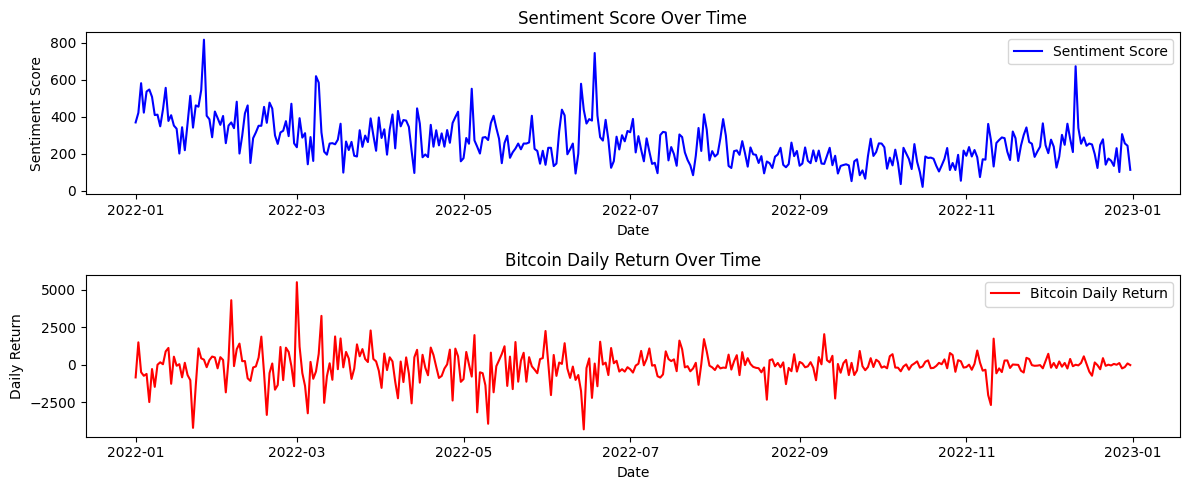

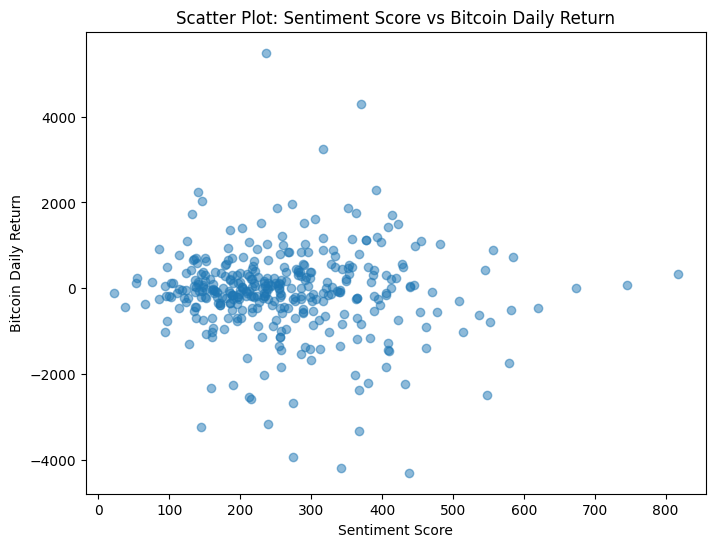

In [11]:
import matplotlib.pyplot as plt

# Visualization
plt.figure(figsize=(12,5))
plt.subplot(2,1,1)
plt.plot(merged_df["date"], merged_df["sentiment_score"], label="Sentiment Score", color="blue")
plt.xlabel("Date")
plt.ylabel("Sentiment Score")
plt.title("Sentiment Score Over Time")
plt.legend()

plt.subplot(2,1,2)
plt.plot(merged_df["date"], merged_df["daily_return"], label="Bitcoin Daily Return", color="red")
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.title("Bitcoin Daily Return Over Time")
plt.legend()

plt.tight_layout()
plt.show()

# Scatter plot
plt.figure(figsize=(8,6))
plt.scatter(merged_df["sentiment_score"], merged_df["daily_return"], alpha=0.5)
plt.xlabel("Sentiment Score")
plt.ylabel("Bitcoin Daily Return")
plt.title("Scatter Plot: Sentiment Score vs Bitcoin Daily Return")
plt.show()


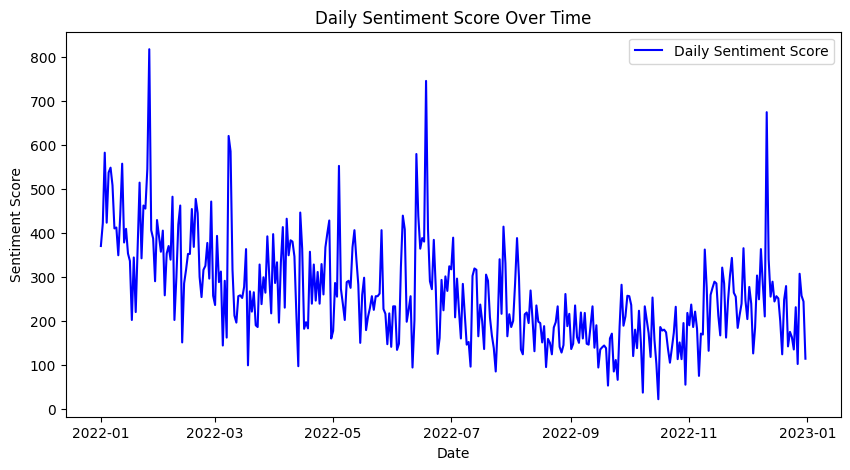

In [12]:
# 1. Sentiment Score Over Time

import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(daily_sentiment["date"], daily_sentiment["sentiment_score"], label="Daily Sentiment Score", color="blue")
plt.xlabel("Date")
plt.ylabel("Sentiment Score")
plt.title("Daily Sentiment Score Over Time")
plt.legend()
plt.show()


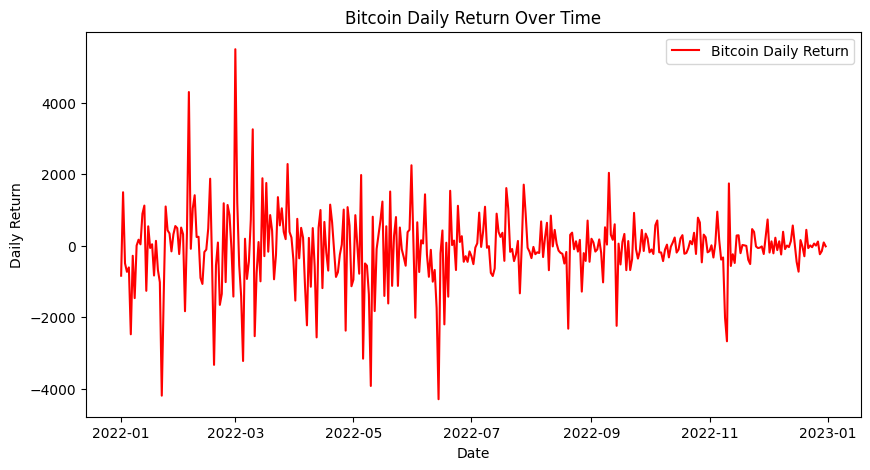

In [13]:
# 2. Bitcoin Daily Return Over Time

plt.figure(figsize=(10,5))
plt.plot(prices_df["timestamp"], prices_df["daily_return"], label="Bitcoin Daily Return", color="red")
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.title("Bitcoin Daily Return Over Time")
plt.legend()
plt.show()


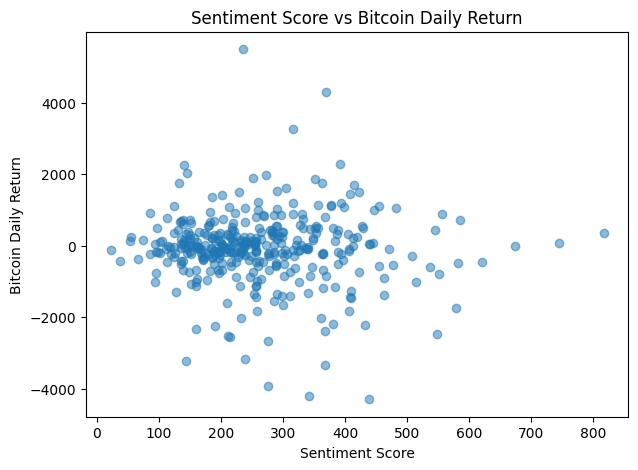

In [14]:
# 3. Sentiment Score vs. Bitcoin Returns Scatter Plot

plt.figure(figsize=(7,5))
plt.scatter(merged_df["sentiment_score"], merged_df["daily_return"], alpha=0.5)
plt.xlabel("Sentiment Score")
plt.ylabel("Bitcoin Daily Return")
plt.title("Sentiment Score vs Bitcoin Daily Return")
plt.show()


If sentiment and price changes were highly related, we’d expect an obvious pattern in the scatter plot.
A flat/no pattern would confirm weak correlation (which is what we observed).